# Exploration 10

## 모듈 불러오기

In [1]:
# !pip install imageio
# !pip install Pillow

In [2]:
import glob
import time
import os

import PIL
import imageio
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
# from google.colab import drive
# drive.mount('/content/drive')

print("tensorflow", tf.__version__)

tensorflow 2.6.0


## 데이터셋 구성하기

CIFAR-10 데이터셋 구성

In [3]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

(50000, 32, 32, 3)

- 학습에 사용 할 `train_x`의 이미지를 -1, 1로 정규화 합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices()함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [4]:
print("Max Pixcel: ", train_x.max())
print("min Pixcel: ", train_x.min())

Max Pixcel:  255
min Pixcel:  0


train_x 의 이미지를 -1, 1로 정규화

In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화

In [6]:
print("Max Pixcel: ", train_x.max())
print("min Pixcel: ", train_x.min())

Max Pixcel:  1.0
min Pixcel:  -1.0


In [7]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32') #reshape
train_x.shape

(50000, 32, 32, 3)

로드한 데이터를 시각화를 통해 확인

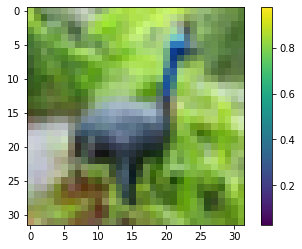

In [8]:
plt.imshow((train_x[6].reshape(32,32,3)+1)/2)
plt.colorbar()
plt.show()

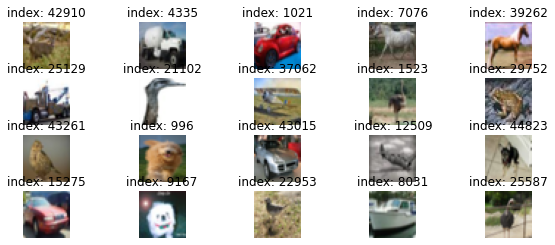

In [9]:
plt.figure(figsize=(10, 5))

for i in range(20):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index].reshape(32,32,3)+1)/2)
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

- tf.data.Dataset 모듈의 from_tensor_slices()함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [10]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
# # 학습시간이 오래걸린다면 아래 함수 참고
# def load_data(label = None):
#     (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
#     if label:
#         df = pd.DataFrame(list(zip(train_x, train_y)), columns = ['image', 'label'])
#         df = df[df['lavel']==label]
#         train_x = np.array([i for i in list(df['image'])])
#         df = pd.DataFrame(list(zip(train_x, train_y)), columns = ['image', 'label'])
#         df = df[df['label']==label]
#         test_x = np.array([i for i in list(df['image'])])
#     return train_x, test_x

## 생성자 모델 구현하기

- (32, 32, 3)의 shape을 가진 이미지 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- `noise = tf.random.normal([1, 100])`로 생성된 랜덤 노이지를 입력으로 하여 방금 구성한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

(32, 32, 3)의 shape을 가진 이미지 생성하는 생성자 모델 구현 함수 작성해 보기.

In [13]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

noise = tf.random.normal([1, 100])로 생성된 랜덤 노이지를 입력하여 방금 구성한 생성자로 랜덤 이미지 생성해보기.

In [14]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [38]:
# noise = tf.random.normal([1,100])

In [39]:
# generated_image = generator(noise, training=False)
# generated_image.shape

TensorShape([1, 32, 32, 3])

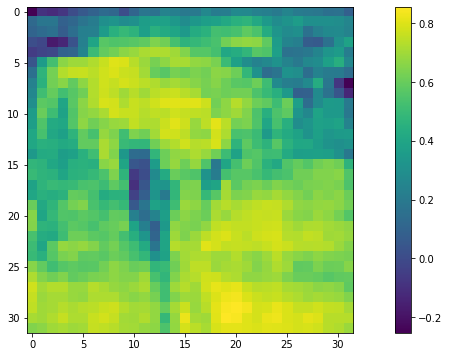

In [40]:
# plt.imshow(generated_image[0, :, :, 0])
# plt.colorbar()
# plt.show()

## 판별자 모델 구현하기

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 "데이터 구성하기"에서 생성한 랜덤 이미지를 판별자 모델이 판결한 결과값을 확인해 봅시다.

In [18]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [19]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

위에서 생성했던 랜덤 이미지를 판별자 모델이 판별한 결과 값을 확인해보기

In [41]:
decision = discriminator(generated_image, training = False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-2.1152422]], dtype=float32)>

## 손실함수와 최적화 함수 구현하기

- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

교차 엔트로피 함수

In [21]:
# 교차 엔트로피 함수
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

generator(생성자)는 fake_output(자신의 가짜 이미지)이 1에 가까워 지기를 바라므로 `tf.ones_like` 를 사용한다.

In [22]:
# generator_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

반대로, discriminator(판별자)는 real_output(진짜 이미지)이 1에 가까워 지기를, fake_output(생성해 낸 이미지)이 0에 가까워 지기를 바라므로 loss값을 모두 계산한다.

In [23]:
# discriminator_loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


판별자가 real output, fake output을 얼마나 정확하게 판별하는지를 계산하는 accuracy

- 1. `tf.math.greater_equal(real_ouput, tf.constant([0.5])`: output의 각 원소가 0.5 이상인지 True / False로 판별함.
- 2. `tf.cast( 위의결과, tf.float32)`: Ture -> 1.0, False -> 0.0
- 3. `tf.reduce_mean( 2번 )`: 2번의 결과를 평균을 내어 정확도 (accuracy) 계산.

In [24]:
# discriminator_accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

최적화 함수(optimizer)
- 생성자와 구분자는 개별 네트워크 이기 때문에 optimizer를 따로 만든다.

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

학습이 어떻게 진행되는지 확인하기 위해 생성자가 샘플 확인
- 한번에 16장 생성
100차원의 노이즈를 총 16개

In [26]:
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 상세 기능 구현하기

- 1개 미니배치의 훈련과정을 처리하는 `train_step()`함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화 하는 `generate_and_save_images()` 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화 하는 `draw_train_histoty` 함수를 구현해 봅시다.
- `training_checkpoints` 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint모듈을 설정해 봅시다.


train_step 함수 구현하기
- (1) 입력 데이터: Real Image 한 세트를 입력받음.
- (2) 생성자 입력 노이즈: generator가 Fake Image를 생성하기 위한 `noise`를 `images` 한 세트와 같은 크기인 `BATCH_SIZE` 만큼 생성.
- (3) `tf.GradientTape()`는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 `with` 구문 열기.
- (4) generated_images 생성: generator가 `noise`를 입력받은 후 `generated_images` 생성.
- (5) discriminator 판별: discriminator가 Real Image인 `images`와 Fake Image인 `generated_images`를 각각 입력받은 후 `real_output`, `fake_output` 출력.
- (6) loss 계산: `fake_output`, `real_output`으로 generator와 discriminator 각각의 loss 계산.
- (7) accuracy 계산: `fake_output`, `real_output`으로 discriminator의 정확도 계산.
- (8) gradient 계산: `gen_tape`와 `disc_tape`을 활용 해 gradient를 자동으로 계산.
- (9) 모델 학습: 계산된 gradient를 optimizer에 압력해 가중치 갱신.
- (10) 리턴값: 이번 스텝에 계산된 loss와 accuracy를 리턴.


In [27]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

학습 현황을 볼 수 있는 샘플을 생성하는 함수.
- 고정된 seed를 이용하여 결과물을 만들어 내므로, 고정된 seed에 대한 결과물이 얼마나 나아지는지 확인할 수 있다.

In [28]:
# def generate_and_save_images(model, epoch, it, sample_seeds):
#     predictions = model(sample_seeds, training = False)

#     fig = plt.figure(figsize = (4,4))
#     for i in range(predictions.shape[0]):
#         plt.subplot(4,4, i+1)
#         plt.imshow(predictions[i, :, :, 0])
#         plt.axis('off')
    
#     plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/tanh/sample_epoch_{:04d}_iter_{:03d}.png'
#                     .format(os.getenv('HOME'), epoch, it))
#     plt.show()

In [29]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    
    predictions = (predictions + 1) / 2.0
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :]) #plt.imshow(predictions[i])
        plt.axis('off')
        
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/tanh/sample_epoch_{:04d}_iter_{:03d}.png'
                     .format(os.getenv('HOME'), epoch, it))
    plt.show()

`gen_loss`, `disc_loss`, `real_accuracy`, `fake_accuracy` 값을 가지는 history 라는 dict 구조로 매 에포크마다 저장하는 함수 만들기

In [30]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 # matlab 차트의 기본 크기인 15,6 지정.

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc = 'upper left')

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/tanh/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

Checkpoint 만들기.
- 모델이 복잡하고 학습 속도가 오래걸릴 수록 필수적이다.
- checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장해준다.
- 정확하게는, 생성자와 판별자가 학습한 모델 가중치를 저장하는 것.

In [31]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints/tanh'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)


## 학습 과정 진행하기

- 위 "손실함수와 최적화 함수 구현하기" 에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만들 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif파일, 학습 진행 그래프 이미지를 함께 제출합니다.

####참고
학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때 마다 모델 학습을 처음부터 다시 진행하면 시간 낭비가 될 것입니다.
우리는 위에서 checkpoint모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint모듈을 활용하여 모델을 로드하는 예시입니다.

위의 함수들을 이용하여 학습 함수 만들기

In [32]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 ==0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print("Epoch {} | iter {}".format(epoch+1, it+1))
                print("Time for epoch {}: {} sec".format(epoch+1, int(time.time()-epoch_start)))
        
        if (epoch +1) % save_every == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training: {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [33]:
save_every = 30
EPOCHS = 600

# 사용 가능한 GPU 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

학습시작

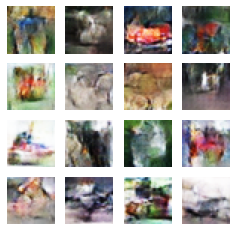

Time for training: 10397 sec


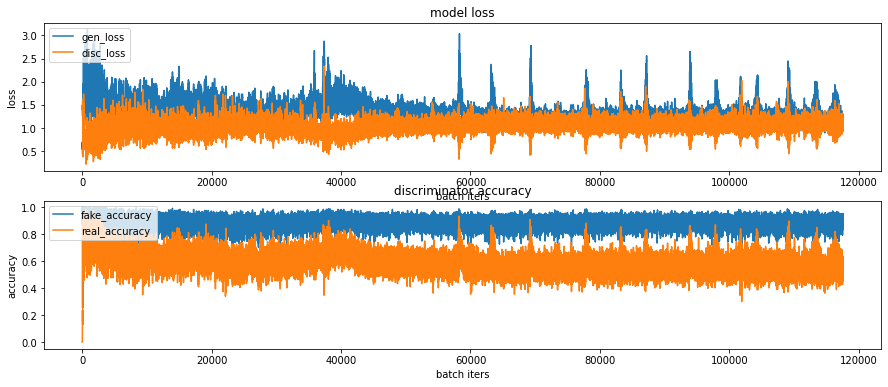

CPU times: user 2h 59min 13s, sys: 13min 16s, total: 3h 12min 30s
Wall time: 2h 53min 23s


In [34]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 /training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

.gif로 만들기

In [35]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan_tanh.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/tanh/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1380048 Feb 15 06:16 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


그래프도 .gif로 만들기

In [36]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/loss_accuracy_tanh.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/training_history/tanh/train_history_*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/loss_accuracy_tanh.gif

-rw-r--r-- 1 root root 1954560 Feb 15 12:28 /aiffel/aiffel/dcgan_newimage/fashion/loss_accuracy_tanh.gif


# 회고

## 이번 프로젝트에서 어려웠던 점
#### 먼저, LMS실습시에는 흑백 사진을 가지고 하였는데, RGB값으로 바꾸는 과정에서 스스로 해결하지 못해 어려웠습니다.
- 단지 체널만 찾아서 1에서 3으로만 바꾸어 주면 된다는 쉬운 개념만 생각 하였었는데, `train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')` 라는 코드를 한 줄 넣어 줘야 한다는 것을 생각해 내지 못했습니다. 처음에는 이 사실을 알지 못해서 주말 동안에, 제가 만든 모델의 이미지 결과가 좋지 않아서, 이를 개선하기 위해 정말 다양한 부분에서 찾아보았는데, 그렇다할 결과를 얻지 못했었습니다. 결과가 좋아 보이지 않았던 이유는, 단순히 제가 모델의 구조를 제대로 갖추지 못하였기 때문이라고 생각하였었는데, 화요일 실습 시간에 다른 분들에게 조언을 구한 뒤에야 제가 reshpae을 하지 않았다는것을 알게 되었습니다. 정말 절망스러웠습니다.. 다들 저와 같은 고민을 하며 제대로된 형상을 이루지 못하고 있다고 생각 했었는데, 정말 충격적이었습니다. 다른분들은 그렇다 할 형상을 갖추면서, 단지 어떤 그림인지 알기 어려운 정도였고, 제가 했던 고민은 단순히 노란색, 파란색의 향연이었을 뿐이었습니다. 단순히 이 사실을 혼자 찾아내지 못하여서 제 주말을 모두 소비하였고, 다른 조는 잘 모르겠지만, 적어도 저희조 내에서는 저 값을 추가해 주지 못한게 저 뿐이라는 사실에, 일차적으로 충격적 이었고, 지금까지 내가 Explolation을 헛 한건 아닐까, 아직 데이터 전처리 부분에서도 이해하지 못한 나 라는 사실에 너무 큰 좌절감을 안겨주었습니다 .. 조금 흥분해서 말이 많았네요.. 아무튼 이로인해 정말 강한게 한대 맞은 기분마냥 큰 동기부여가 되었습니다. 이로인해 무너질 수도 있었지만, 일어나서 계속 걸어가는것을 택하기로 하였습니다.

#### 다음은 generator 모델과 discriminator 모델을 만드는 과정에서 레이어 별 활성화 함수 이해하는 부분이 어려웠습니다.
- 개인적으로 이것 저것 실험해 보고 싶은 부분이 많았습니다. 전체적인 활성화 함수의 역할에 대해서는 이해하였으나, 이를 활용하여 사용하는 데에 있어서 제대로 이해하고 있지 못해서 인지 이를 사용할 수 없다는 점이 제게 너무 마음아팠습니다. 우선 고작해야 활성화 함수를 tanh 에서, ReLU, sigmoid, softmax 등으로 바꾸어 보는 시도를 해 보았었는데, 위에 말씀드린 reshape을 하지 않은 상태에서 이루어 진 실험이었기에 모두 수포로 돌아가고 말았습니다. 때문에 시간상 가장 기본 하이퍼 파라미터를 이용하여 모델을 학습하였습니다.

## 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
#### 먼저, 가장 큰 충격을 안겨주었다는 흑백 실습에서, 색 이미지 실습일 때의 데이터 전처리에 대해 잘 알았습니다.
- 이 부분은 이번 저의 노드에 모든것을 앗아갔기 때문에, 다음에 색 이미지 파트가 나온다면 절대로 잊지 않을것입니다.

#### 활성화 함수에 대해 많이 알게되었습니다.
- 각종 용어들은 이전에도 들어본 적은 있었으나, 어떤 역할을 하는지 잘 몰랐는데, 이번 실습을 통하여 활성화 노드의 차이점 들에 대해 알게되었습니다. 예를들어 sigmoid 는 0~1 사이의 값을 만들 때 사용하고 보통 분류문제에서 결과 확률해석, 이진 분류를 하고자 할 때 이용한다는것을 알았고, thah는, 기울기 소실현상이라는 단점이 있지만, 시그모이드보다 범위가 넒고, 효율적이라는 것을 알았고, ReLU는 다른 활성화 함수에 비해 학습이 빠르며, 기울기 소실 문제를 해결하였다는 것을 알 수 있었으며, 이에 관련하여 Leaky ReLU 가 있다는 것을 알게되었습니다

#### 하지만, 아직 이를 활용하는 부분에 대해서는 모호합니다.
- 활성화 함수에 대해 알게되었기 때문에, 이번 실습을 통하여 여러가지 실험을 하고싶었습니다. 하지만 이론적인 내용은 알게되었지만, 이를 사용하여 그 이론을 직접 몸으로 느끼지도 못하였을 뿐더러, 어떤 레이어에 어떻게 활용하면 좋을지에 대한 감이 아직 잡히지 않았기에 함부러 추가, 제거할 수 없었습니다. 아마 아직 레이어의 개념에 대해, 학습 방법에 대한 지식이 부족하다고 느꼈기 때문에 다시 기초 Fundamental노드를 복습하여 하나씩 알아가 볼 예정입니다.

## 루브릭 지표를 맞추기 위해 시도한 것들
#### 오브젝트 종류를 육안으로 구별할 수 있을만한 이미지를 생성하였다.
- 에포크가 진행 될 때마다 그렇다할 형상은 모이는데 단지 뿌옇다 라고 판단하였기에, 에포크 값을 1000혹은 2000으로 하면 좀 더 선명하지 않을까? 라고 생각하였습니다. 시도해 보고싶었지만, 제출 시간이 얼마 남지 않았기에, 600정도도 충분히 큰 값이라 생각하였기에 600으로 하였습니다.

#### gif를 통해 생성 이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해가고 있음을 확인하였다.
- 완벽한 0.5값을 찾아내지는 못하였지만, 에포크 값이 늘어남에 따라, 점점 줄어드려고 노력하는, 마치 소리나 지진그래프 같은 형상을 확인할 수 있었습니다.

#### 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.
- 활성화 함수를 추가 및 제거하거나, 레이어를 수정하고싶었지만, 단순히 dropout을 빼는 것 밖에 시도하지 못하였습니다. 애초에 제출하기 전 마지막 학습을 제외하고는 처음부터 값이 잘못되어 제대로 판단할 수 없었기에, 이전 아이디어와 비교할 수 없었습니니다...


## 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정.

#### 모델을 개선하지 않았기 때문이라고 생각합니다.
- 우선 fake accuracy가 추세적으로 점차 나아지고 있기는 하였으나, 0.5값을 보여주지는 못하였습니다. loss 값은 점차적으로 만나게 되어 균형을 유지하는 모습이 인상적이었는데, accuraacy는 그러지 못하였습니다.

- 또한, 레이어에 활성화 함수 등을 추가 및 제거 하지 않았기에 모델 개선이 전혀 이루어지지 않았습니다.

- 때문에, 루브릭 지표 2번, 3번의 문제로 인해, 혹은 1번도 모호하기에, 이 점이 루브릭 지표를 달성하지 못하게 하지 않았을까 추정해봅니다.


## 자기 다짐
- 매번 Exploration을 할 때 마다 느끼지만, 우선 큰 틀을 잡고 거기서 하나씩 실험하며 시도하며 그로인해 배우고 지식을 넓혀가며 모델까지 개선시키는 것이 목표였습니다. 하지만 주말동안에, 코드를 복사하지 않고 일일이 손으로 타이핑 하겠다라는 욕심이, 쓸데없는 대괄호 하나를 잘못 넣어, 이 오류를 발견하는데 2시간 넘게 소비를 하였고, 또한 모델이 돌아가고, 단지 그 결과값이 성능이 좋지 않다라고 생각한 저의 오판 때문에, 결국 마지막에 조원들의 도움을 받아 그제서야 해결하였고, 때문에 제출에 쫓겨 결국 아무런 실험도 못한 체 끝이 났습니다.
- 이로인해 정말 다음에는 어디서 어떻게 해야하는가에 대한 고찰을 많이 하게 되었습니다. 코드는 절대 복사하지 않고 직접 손으로 치며 한 부분 한 부분 짚고 넘어간다라는 저의 고지식하지만, 고된 철학이, 이를 포기해야하나 라는 생각도 하게 만들었으며, 가장 기본적인 색 이미지 전처리도 부분 때문에 며칠에 걸려 고민한 부분이 애초에 잘못되었다는 것을, 스스로가 아닌, 조원들을 통해 알게되어, 지금까지 제가 진도를 최대한 따라가 보고자하고 세심하게 안고 가지 못했던 부분이 이렇게 부메랑이 되어 돌아오는구나 하고 느끼게 되었습니다.
- 솔직한 심정으로는 잘 모르겠습니다. 큰 벽을 마주한 기분입니다. 벌써 아이펠 몇 주차에 접어들었고, 매 주, 매 일, 나름의 공부방식과 나름의 패턴을 찾고 그 철학 안에서 움직이려 했던 제 방식에, 오늘 이 시간 이후로 완전히 뒤집혀 버렸습니다. 정말 크게 무너질 뻔 하였으나, '큰 벽이 제 앞에 있으면 어떠랴, 다시 처음 시작하면 지금보다 나으리' 라는 마음으로, 진도에 급급한 제 자신이 아닌, 백 가지중 단 한 가지만 가져가더라도, "배웠다" 라고 느낄 수 있는 학습을 해야겠다라는 고찰을 합니다.